In [1]:
import torch as t
import torch
import torch_geometric as pyg
from torch_geometric.data import Data, HeteroData
from torch_geometric.loader import NeighborLoader

import networkx as nx
import matplotlib.pyplot as plt 

## Graph setup

In [2]:
hd = pyg.data.HeteroData()

hd['Cells'].x = torch.arange(4)*10
hd['Cells'].y = torch.arange(4)*10

hd['Paths'].x = torch.arange(3)*100
hd['Genes'].x = torch.arange(4)*1000

hd['Paths'].y = torch.arange(3)*100
hd['Genes'].y = torch.arange(4)*1000

hd['Cells', 'express', 'Paths'].edge_index = torch.LongTensor([
    [0, 1, 1, 2, 2, 3],
    [0, 0, 1, 1, 2, 2]
])

hd['Paths', 'contain', 'Genes'].edge_index = torch.LongTensor([
    [0, 0, 1, 1, 2],  # [3, 2, 2, 1, 0 ]
    [3, 2, 2, 1, 0]    # [0, 0, 1, 1, 2 ]
])


## Batching nodes

In [3]:
hd = pyg.transforms.ToUndirected()(hd)
input_nodes=('Cells', torch.Tensor([1,2])) # ie only batch['Cells'].x = [10,20] should be returned

batch_size = 3
loader = NeighborLoader(
    hd,
    num_neighbors=[2,2],
    batch_size=batch_size,
    input_nodes=input_nodes,
    directed=True,
    #replace=False
)
batch = next(iter(loader))

In [4]:
len(loader) # this is len=1 because the nodes in the `input_nodes` param is less than batch_size?

1

In [5]:
bs = batch['Cells'].batch_size
batch.edge_index_dict[('Cells', 'express', 'Paths')]

tensor([[2, 0, 0, 1, 1, 3],
        [0, 0, 1, 1, 2, 2]])

In [6]:
# If I use the batch_size returned, I can filter out only the nodes in the train mask
batch['Cells'].x[:bs]

tensor([10, 20])

In [7]:
# if I try that same filtering on the edges, it **doesnt** omit cells edges in the train mask
batch.edge_index_dict[('Cells', 'express', 'Paths')][:,:bs]

tensor([[2, 0],
        [0, 0]])

### viz

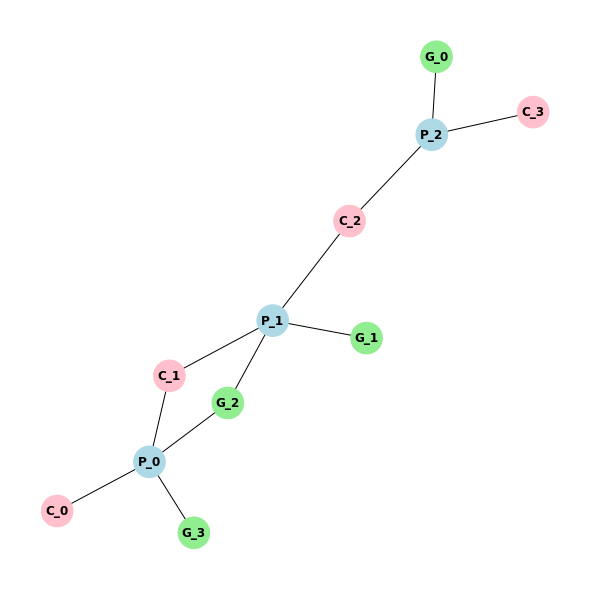

In [10]:
from utils import plot_graph
plot_graph(hd)

In [8]:
def filter_edges(batch: pyg.data.HeteroData, edge_type: str, allowed_idx: list):
    """Filter out edges to only contain the edges in the `allowed_idx` variable
    Args: 
        edge_path (tuple of strings): example: ('Cells', 'express', 'Paths')
    """
    
    allowed_idx = [i for i,_ in enumerate(batch['Cells'].x[:2])]
    e = batch.edge_index_dict[edge_type]
    new_row, new_col = [], []
    for i, node in enumerate(e[0]):
        if node in allowed_idx:
            new_row.append(node)
            new_col.append(e[1][i])
    new_e = torch.stack([torch.Tensor(new_row), 
                        torch.Tensor(new_col)]) 
    return new_e

In [9]:
# as a fix, I filter out only the edges I care about but I am not sure if this is right
allowed_idx = [i for i,_ in enumerate(batch['Cells'].x[:bs])]

filter_edges(batch, ('Cells', 'express', 'Paths'), allowed_idx)
#filter_edges(batch, ('Paths', 'rev_express', 'Cells'), allowed_idx)


tensor([[0., 0., 1., 1.],
        [0., 1., 1., 2.]])

In [ ]:
# in the above, the source nodes are always nodes either [0,1] because that's whats in my train mask